In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fldr = '/content/drive/MyDrive/Đại số máy tính/data/UTKFace'

In [ ]:
files=os.listdir(fldr)
print(int(files[0].split('_')[0]))
print(files[0])

28
28_0_3_20170119194504450.jpg.chip.jpg


In [ ]:
import cv2
ages=[]
genders=[]
images=[]

for i, fle in enumerate(files):
  age=int(fle.split('_')[0])
  gender=int(fle.split('_')[1])
  total=fldr+'/'+fle
  image=cv2.imread(total)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image= cv2.resize(image,(48,48))
  images.append(image)
#   if i % 1000 == 0:
#     print(i)

In [ ]:
for fle in files:
  age=int(fle.split('_')[0])
  gender=int(fle.split('_')[1])
  ages.append(age)
  genders.append(gender)

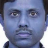

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(images[24])

In [ ]:
print(ages[24])
print(genders[24])

28
0


In [ ]:
import numpy as np
images_f=np.array(images)
genders_f=np.array(genders)
ages_f=np.array(ages)

In [ ]:
np.save('/content/drive/MyDrive/Đại số máy tính/data/image.npy',images_f)
np.save('/content/drive/MyDrive/Đại số máy tính/data/gender.npy',genders_f)
np.save('/content/drive/MyDrive/Đại số máy tính/data/age.npy',ages_f)

In [ ]:
values, counts = np.unique(genders_f, return_counts=True)
print(counts)

[7975 8526]


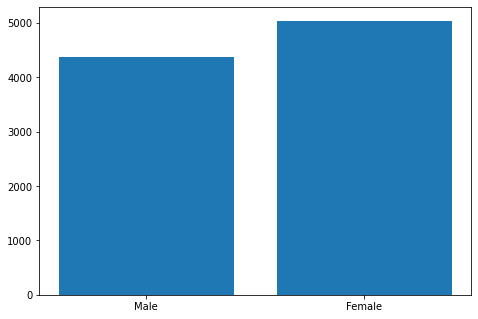

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
gender = ['Male', 'Female']
values=[4372,5047]
ax.bar(gender,values)
plt.show()

In [ ]:
values, counts = np.unique(ages_f, return_counts=True)
print(counts)

[1124  482  289  156   65  130   81  157  177  247  158  262   98  284
  346  395  426  859  734 2197  615  918  570  724  350  664  143  409
  880  483  293  325  266  526  132  266  157   81   11    2    1    5
    5    1    3    4]


In [ ]:
val=values.tolist()
cnt=counts.tolist()

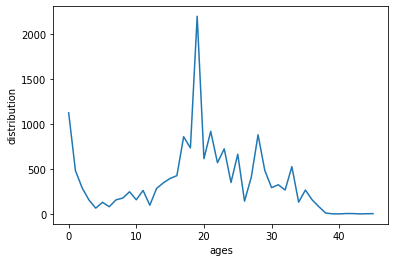

In [ ]:
plt.plot(counts)
plt.xlabel('ages')
plt.ylabel('distribution')
plt.show()

In [ ]:
labels=[]

i=0
while i<len(ages):
  label=[]
  label.append([ages[i]])
  label.append([genders[i]])
  labels.append(label)
  i+=1

In [ ]:
images_f_2=images_f/255
labels_f=np.array(labels)
images_f_2.shape

(16501, 48, 48, 3)

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test= train_test_split(images_f_2, labels_f,test_size=0.25)

In [ ]:
Y_train[0:5]

array([[[20],
        [ 1]],

       [[26],
        [ 1]],

       [[26],
        [ 0]],

       [[13],
        [ 1]],

       [[26],
        [ 0]]])

In [ ]:
Y_train_2=[Y_train[:,1],Y_train[:,0]]
Y_test_2=[Y_test[:,1],Y_test[:,0]]

In [ ]:
Y_train_2[0][0:5]

array([[1],
       [1],
       [0],
       [1],
       [0]])

In [ ]:
Y_train_2[1][0:5]

array([[20],
       [26],
       [26],
       [13],
       [26]])

Model

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def Convolution(input_tensor,filters):
    
    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1),kernel_regularizer=l2(0.001))(input_tensor)
    x = Dropout(0.1)(x)
    x= Activation('relu')(x)

    return x
def model(input_shape):
  inputs = Input((input_shape))
  
  conv_1= Convolution(inputs,32)
  maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)
  conv_2 = Convolution(maxp_1,64)
  maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)
  conv_3 = Convolution(maxp_2,128)
  maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)
  conv_4 = Convolution(maxp_3,256)
  maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)
  flatten= Flatten() (maxp_4)
  dense_1= Dense(64,activation='relu')(flatten)
  dense_2= Dense(64,activation='relu')(flatten)
  drop_1=Dropout(0.2)(dense_1)
  drop_2=Dropout(0.2)(dense_2)
  output_1= Dense(1,activation="sigmoid",name='sex_out')(drop_1)
  output_2= Dense(1,activation="relu",name='age_out')(drop_2)
  model = Model(inputs=[inputs], outputs=[output_1,output_2])
  model.compile(loss=["binary_crossentropy","mae"], optimizer="Adam",
	metrics=["accuracy"])
  
  return model

In [ ]:
Model=model((48,48,3))

In [ ]:
Model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 48, 48, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 48, 48, 32)   0           dropout[0][0]                    
______________________________________________________________________________________________

Training

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

In [ ]:
save = Model.fit(X_train,Y_train_2,batch_size=64,validation_data=(X_test,Y_test_2),epochs=100)
Model.save('/content/drive/MyDrive/Đại số máy tính/data/Age_sex_detection.h5')

Evaluation

In [ ]:
Model.evaluate(X_test,Y_test_2)

129/129 [==============================] - 1s 7ms/step - loss: 4.9122 - sex_out_loss: 0.2596 - age_out_loss: 4.3106 - sex_out_accuracy: 0.8815 - age_out_accuracy: 0.0652


[4.912228107452393,
 0.2595677971839905,
 4.310571670532227,
 0.881483256816864,
 0.06519631296396255]

In [ ]:
pred=Model.predict(X_test)

In [ ]:
pred[1]

array([[ 1.1339257],
       [23.45388  ],
       [28.534405 ],
       ...,
       [15.620618 ],
       [28.470036 ],
       [33.014793 ]], dtype=float32)

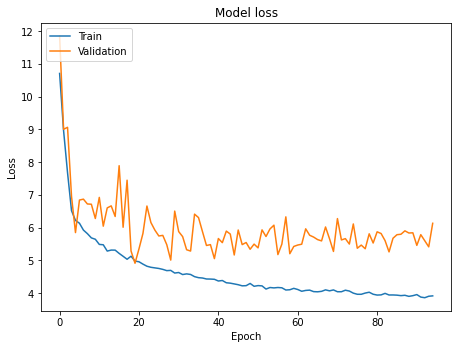

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

For gender

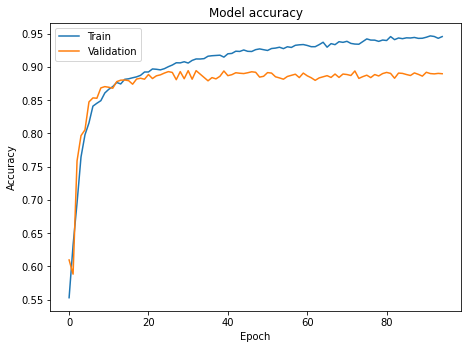

In [ ]:
plt.plot(History.history['sex_out_accuracy'])
plt.plot(History.history['val_sex_out_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25,
                        wspace=0.35)

For age

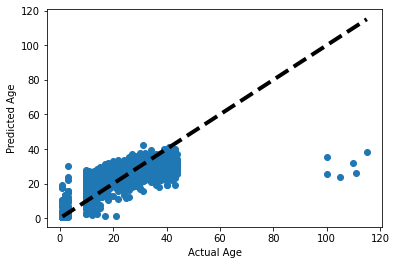

In [ ]:
fig, ax = plt.subplots()
ax.scatter(Y_test_2[1], pred[1])
ax.plot([Y_test_2[1].min(),Y_test_2[1].max()], [Y_test_2[1].min(), Y_test_2[1].max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age')
plt.show()

For gender

In [ ]:
i=0
Pred_l=[]
while(i<len(pred[0])):

  Pred_l.append(int(np.round(pred[0][i])))
  i+=1

In [ ]:
from sklearn.metrics import confusion_matrix 

from sklearn.metrics import classification_report 

In [ ]:
report=classification_report(Y_test_2[0], Pred_l)

print(report)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2006
           1       0.89      0.88      0.88      2120

    accuracy                           0.88      4126
   macro avg       0.88      0.88      0.88      4126
weighted avg       0.88      0.88      0.88      4126



In [ ]:
results = confusion_matrix(Y_test_2[0], Pred_l)

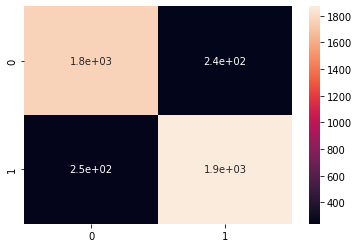

In [ ]:
import seaborn as sns

sns.heatmap(results, annot=True)

In [ ]:
def test_image(ind,images_f,images_f_2,Model):
#   cv2_imshow(images_f[ind])
  plt.imshow(images_f[ind])
  image_test=images_f_2[ind]
  pred_1=Model.predict(np.array([image_test]))
  #print(pred_1)
  sex_f=['Male','Female']
  age=int(np.round(pred_1[1][0]))
  sex=int(np.round(pred_1[0][0]))
  print("Predicted Age: "+ str(age))
  print("Predicted Sex: "+ sex_f[sex])

Predicted Age: 23
Predicted Sex: Female


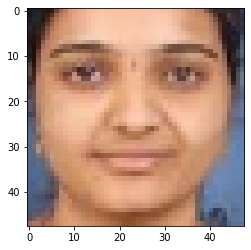

In [ ]:
test_image(57,images_f,images_f_2,Model)

Predicted Age: 29
Predicted Sex: Male


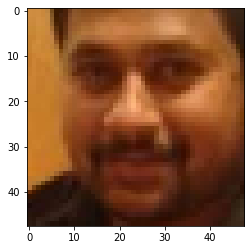

In [ ]:
test_image(100,images_f,images_f_2,Model)

Predicted Age: 28
Predicted Sex: Male


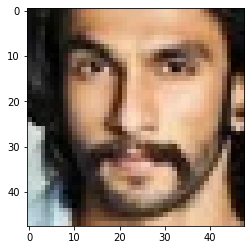

In [ ]:
test_image(200,images_f,images_f_2,Model)

Predicted Age: 26
Predicted Sex: Female


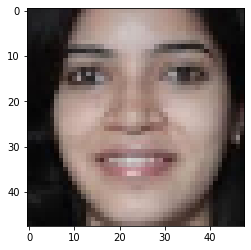

In [ ]:
test_image(69,images_f,images_f_2,Model)